Information 
- http://host.robots.ox.ac.uk/pascal/VOC/voc2007/ (dataset)
- https://github.com/keshik6/pascal-voc-classification/tree/master (github inspo)
- http://host.robots.ox.ac.uk/pascal/VOC/voc2007/devkit_doc_07-Jun-2007.pdf 

## Dependencies 

In [18]:
from dataset import PascalVOC_Dataset   # access datasets from torchvision 
from torchvision import transforms      # do some transforms, yk 
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

## Prepare Dataset
1) Transformations 
2) Reading Data

In [8]:
transformations = transforms.Compose([
    transforms.Resize((300, 300)),
    # transforms.RandomChoice([
        # transforms.CenterCrop(300),
        # transforms.RandomResizedCrop(300, scale=(0.80, 1.0)),
    # ]),                                      
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=(0.80, 1.20)),
        transforms.RandomGrayscale(p = 0.25)
    ]),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomRotation(25),
    transforms.ToTensor(), 
    # transforms.Normalize(mean = mean, std = std),
])

# no crazy stuff for validation data        
transformations_valid = transforms.Compose([
    transforms.Resize(330), 
    transforms.CenterCrop(300), 
    transforms.ToTensor(), 
    # transforms.Normalize(mean = mean, std = std),
])

In [10]:
data_dir = './Dataset/VOC2007'

dataset_train = PascalVOC_Dataset(
    data_dir,
    year='2007', 
    image_set='train',
    download=False,
    transforms=transformations
)

dataset_val = PascalVOC_Dataset(
    data_dir,
    year='2007',
    image_set='val',
    download=False,
    transform=transformations_valid
)

dataset_test = PascalVOC_Dataset(
    data_dir,
    year='2007', 
    image_set='test',
    download=False
)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [22]:
image,target = dataset_train.__getitem__(14)

## Visualize Dataset

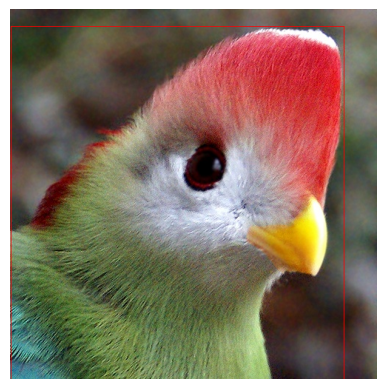

In [23]:
def display_image_with_boxes(image, target):
    # Convert the image from tensor to PIL Image

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Get bounding box coordinates from the target dictionary
    for box in target['annotation']['object']:
        bbox = [int(box['bndbox']['xmin']), int(box['bndbox']['ymin']), int(box['bndbox']['xmax']),
                int(box['bndbox']['ymax'])]
        draw.rectangle(bbox, outline='red')

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image_with_boxes(image,target)

## Optimizer

## Training

## Testing 

## Quantitative Evaluation